# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI()

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [2]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


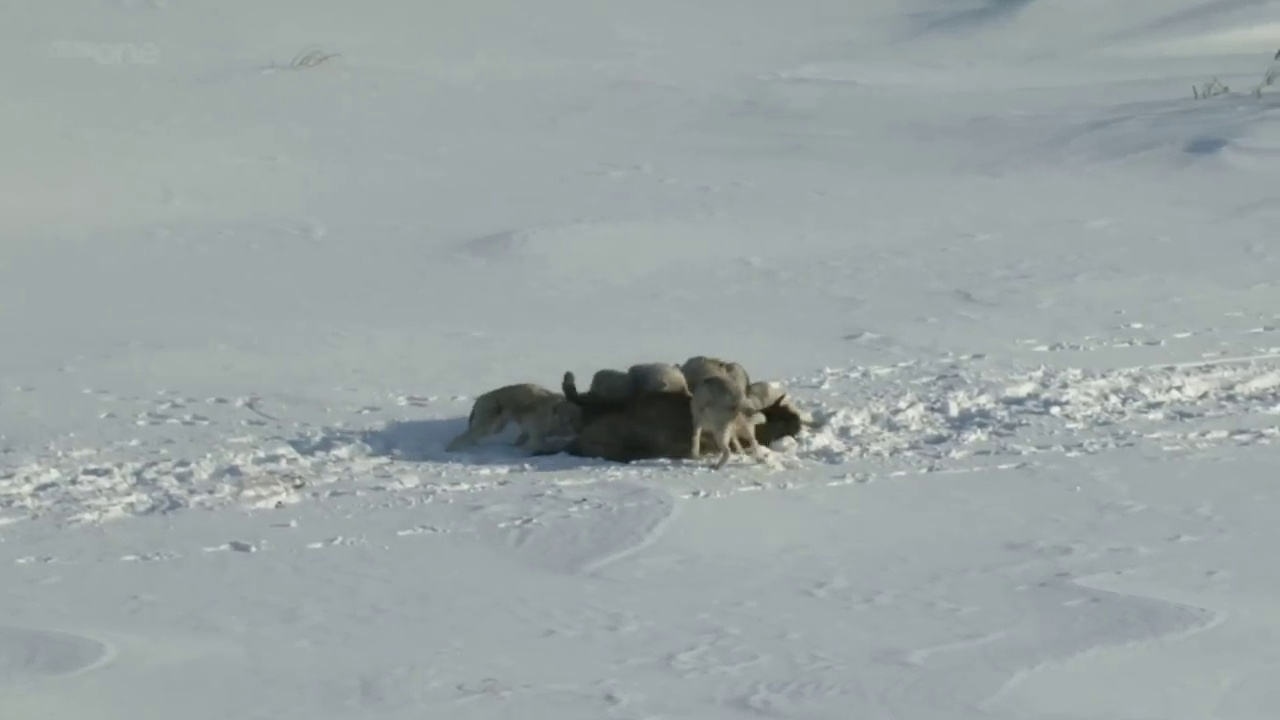

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [4]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

"🐺 Survival of the Fittest: An Epic Tale in the Snow ❄️ - Witness the intense drama of nature as a pack of wolves face off against mighty bison in a harsh winter landscape. This raw footage captures the essence of the wild where every creature fights for survival. With each frame, experience the tension, the strategy, and the sheer force exerted in this life-or-death struggle. See nature's true colors in this gripping encounter on the snowy plains. 🦬"

Remember to respect wildlife and nature. This video may contain scenes that some viewers might find intense or distressing, but they depict natural animal behaviors important for ecological studies and understanding the reality of life in the wilderness.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

In the vast, white expanse of the northern wilderness, a drama as old as time unfolds. Here, amidst the silence of the snow, the wolf pack circles, their breaths visible as they cautiously approach their formidable quarry, the bison. These wolves are practiced hunters, moving with strategic precision, yet the bison, a titan of strength, stands resolute, a force to be reckoned with.

As tension crackles in the frozen air, the wolves close in, their eyes locked on their target. The bison, wary of every movement, prepares to defend its life. It's a perilous dance between predator and prey, where each step could be the difference between life and death.

In an instant, the quiet of the icy landscape is shattered. The bison charges, a desperate bid for survival as the pack swarms. The wolves are relentless, each one aware that their success depends on the strength of the collective. The bison, though powerful, is outnumbered, its massive form stirring up clouds of snow as it struggles.

It'

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [6]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)